# Topic Modeling

## Import Modules

In [93]:
# Import Modules

import re
import numpy as np
import pandas as pd
from pprint import pprint
import random
np.random.seed(42)

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, Word2Vec, LdaModel
from gensim.test.utils import common_corpus, common_dictionary
from gensim.corpora import Dictionary


# from gensim.models.wrappers import LdaMallet

# spacy for lemmatization
import spacy
# download LLM: python -m spacy download en_core_web_sm

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# import NLTK stop words
import nltk
from nltk.corpus import stopwords
from nltk import tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
#nltk.download('punkt') # run once
#nltk.download('stopwords')  # run once

stop_words_fr_path = "fr-stop-oa.txt"
stop_words_eng = stopwords.words('english')
stop_words_fr = stopwords.words('french')
with open(stop_words_fr_path, 'r') as f:
    stop_words_fr = set(f.read().splitlines())

print(list(stop_words_fr)[:10])

ex = 'de'
print([ex if ex not in stop_words_fr else ex + ' found in stopwords'])
'''
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
'''
mallet_path = "/Users/aaron68lee/Documents/Coding-Projects/NLP-Research/Mallet"


['quatrièmement', 'cependant', 'différentes', 'quatrième', 'vous-mêmes', 'chez', 'tel', 'deuxièmement', 'dix-huit', 'très']
['de found in stopwords']
True


## Import Datasets

In [35]:
'''
Document Extractor
'''

import io
import os.path
import re
import tarfile

import smart_open

# Filter for only nouns (in preprocessing)
def noun_only(x):
    pos_comment = nltk.pos_tag(x)
    filtered = [word[0] for word in pos_comment if word[1] in ['NN']]
    # to filter both noun and verbs
    #filtered = [word[0] for word in pos_comment if word[1] in ['NN','VB', 'VBD', 'VBG', 'VBN', 'VBZ']]
    return filtered

'''
DESCRIPTION: helper function to process all documents inside a corpus folder
RETURN:
    1) documents: python list of document as one string
    2) document_names: python list of document names (list of strings)
    3) doc_dict: dictionary mapping doc names to doc contents
'''
def extract_documents(url, max_docs=1):
    doc_count = 0
    documents = []
    document_names = []
    doc_dict = {} # combines documents and document_names into dictionary data structure
    
    with os.scandir(url) as entries:
        for entry in entries:
            if doc_count < max_docs:
                if entry.is_file() and entry.name.endswith('.txt'):
                    with open(entry, "r", encoding="utf-8", errors="replace") as file:
                        curr_doc = file.read()
                        curr_doc = tokenize.word_tokenize(curr_doc) # tokenize curr doc
                        lowered = [w.lower() for w in curr_doc] # lowercase
                        # add lemmitization preprocessing later...
                        alpha = [w for w in lowered if w.isalpha()]
                        filtered = [w for w in alpha if w not in stop_words_fr]
                        curr_doc = list(filter(None, filtered))
                        documents.append(curr_doc)
                        # remove below for scalability latency issues
                        document_names.append(entry.name) 
                        doc_dict[entry.name] = curr_doc
                doc_count += 1
    return documents, document_names, doc_dict


In [94]:
######### import datasets and remove stopwords #########

docs_folder_path = "/Users/aaron68lee/Documents/Coding-Projects/NLP-Research/FRconquest_split"
max_docs = 10
max_chars = 500
max_print = 5

docs, doc_names, doc_dict = list(extract_documents(docs_folder_path, max_docs))
print("There are: ", len(docs), " documents in the corpus folder\n")
print("Document Names: ", doc_names[0:min(max_docs, max_print)])
#print("Doc Dictionary: ", doc_dict)
print("Sample abridged doc: \n\n", docs[:max_docs])

#Read each file into the working directory. Remove stop words, non-alphabetical terms, and punctuation. Append each processed file into the docs list. 



There are:  10  documents in the corpus folder

Document Names:  ['Laplagne-Barris_FRconq_s1v07_3.txt', 'Laplagne-Barris_FRconq_s3v03_99.txt', 'Laplagne-Barris_FRconq_s1v08_10.txt', 'Reynaud_Annales-Algeriennes_t1_4.txt', 'Laplagne-Barris_FRconq_s1v01_20.txt']
Sample abridged doc: 

 [['provisoires', 'bardo', 'écuries', 'permanentes', 'terminer', 'caserne', 'construire', 'casernes', 'hommes', 'corps', 'écuries', 'chevaux', 'pavillons', 'officiers', 'prison', 'détenus', 'construire', 'bâtiments', 'accessoires', 'hôpital', 'militaire', 'terminer', 'magasins', 'vivres', 'construire', 'magasins', 'orge', 'travaux', 'nécessiteront', 'dépense', 'francs', 'setif', 'fortifications', 'travaux', 'exécutés', 'ler', 'travaux', 'ordinaires', 'terminé', 'tours', 'réduit', 'intérieur', 'dernière', 'tour', 'converti', 'silos', 'continué', 'travail', 'enceinte', 'ville', 'portion', 'comprise', 'porte', 'sud', 'front', 'bastion', 'élevée', 'jusà', 'hauteur', 'créneaux', 'réparé', 'brèche', 'enceinte', '

## Preprocess Data 

#### Examples 

In [ ]:
# Examples



############# Test Dataset as CSV ################

# Test on sample document

# doc_path = 'FRconquest_split/1838_Tableau-Algeria_pt1_0.txt'

'''
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()

# Pre-process Data
# 1) Remove Punctuation and Stop Words

pprint(data[:1])
'''

'''
# Tokenize the documents.
from nltk.tokenize import RegexpTokenizer

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')

# docs is already list of list of words

# Remove numbers, but not words that contain numbers.
# print(docs[0][0][0])
print(docs[0][:500])
doc_parsed = [[] for _ in range(len(docs))]
for doc in range(len(docs)):
    for j in range(len(docs[doc])):
        if not (docs[doc][j].isnumeric()):
            doc_parsed[doc].append(docs[doc][j])

print(doc_parsed[0][:500])
#docs = [[token for token in doc if not token.isnumeric()] for doc in docs]
#print(docs[0][:500])

# Remove words that are only one character.
#docs = [[token for token in doc if len(token) > 1] for doc in docs]
print("Sample abridged doc: \n\n", docs[0][:500])
'''


### **Remove Stopwords and Create Dictionary**

In [96]:
#The two main inputs to the LDA topic model are the dictionary and the corpus, 
#so we begin by creating the dictionary.

from gensim import corpora, models, similarities
from collections import Counter

#Create dictionary of words. 
dictionary = corpora.Dictionary(docs)
# create token frequency across all docs in corpus
tokens = [token for doc in docs for token in doc] #[[token for token in doc] for doc in docs]
token_freq = Counter(tokens)

#View dictionary and see how many unique tokens it contains.
print(dictionary)
print("Unique total words: ", len(dictionary))
print("Number docs: ", len(docs))

#Create Term-Document Frequency, which also converts tokenized documents to vectors 
corpus = [dictionary.doc2bow(text) for text in docs]

#View
print(corpus[:1][:10])

#Gensim creates a unique ID for each word in the document, and the resulting printout in the View step above,
#shows the mapping: (word_id, word_frequency), so (0,1) means that word ID 0 occurs once in the first document.

Dictionary<7173 unique tokens: ['abattoir', 'abondantes', 'accessoires', 'accès', 'acheté']...>
Unique total words:  7173
Number docs:  10
Top Words:  [('fr', 197), ('idem', 196), ('travaux', 179), ('alger', 174), ('commerce', 97), ('ville', 87), ('année', 83), ('algérie', 82), ('france', 81), ('général', 77)]
[[(0, 1), (1, 1), (2, 6), (3, 1), (4, 3), (5, 2), (6, 5), (7, 2), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 5), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 2), (27, 3), (28, 2), (29, 1), (30, 5), (31, 1), (32, 2), (33, 4), (34, 1), (35, 2), (36, 1), (37, 1), (38, 3), (39, 1), (40, 1), (41, 3), (42, 1), (43, 1), (44, 1), (45, 2), (46, 2), (47, 1), (48, 2), (49, 2), (50, 1), (51, 3), (52, 4), (53, 1), (54, 1), (55, 5), (56, 1), (57, 1), (58, 3), (59, 1), (60, 1), (61, 1), (62, 2), (63, 1), (64, 4), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 2), (75, 1), (76, 1), (77

### Create Token Frequency Table

In [101]:
# Create Dictionary for word frequency table

#Human-readable format of corpus (term-frequency)
freq_chart = [[(dictionary[id], freq) for id, freq in cp] for cp in corpus[:1]]
sorted_freq_chart = sorted(freq_chart[0], key=lambda x: x[1], reverse=True)
print("Top Words: ", token_freq.most_common(10))

#print(freq_chart[0:10])
print(sorted_freq_chart[0:10])
#[[('abattoir', 1), ('abondantes', 1), ('accessoires', 6)]]

Top Words:  [('fr', 197), ('idem', 196), ('travaux', 179), ('alger', 174), ('commerce', 97), ('ville', 87), ('année', 83), ('algérie', 82), ('france', 81), ('général', 77)]
[('travaux', 102), ('francs', 40), ('enceinte', 34), ('dépense', 28), ('extraordinaires', 23), ('faire', 23), ('ordinaires', 22), ('dépensé', 20), ('exécutés', 20), ('hôpital', 20)]


## Hyperparameters: Coherence Scores ##

In [40]:
#compute coherence scores first to determine which number(s) of topics produces the most coherent results.

from gensim.models.coherencemodel import CoherenceModel
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, random_state = 100, passes = 25, chunksize = 100)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0

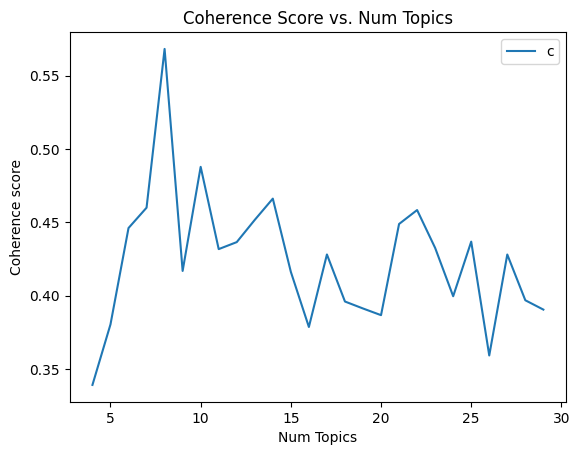

In [103]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=docs, start=4, limit=30, step=1)

#Plot the graph of coherence scores across different number of topics (from start to limit).

import matplotlib.pyplot as plt
limit=30; start=4; step=1
x = range(start, limit, step)
plt.scatter(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title("Coherence Score vs. Num Topics")
plt.legend(("coherence_values"), loc='best')
plt.xticks(x)
plt.show()



## Topic Visualization

In [104]:
#Parameter tuning will lead to different models. For this model, we use our corpus, dictionary, 
#set a random state of 100 (akin to setting a seed for reproduction purposes), 9 topics 
#(optimal number according to coherence scores), 100 passes (number of times the corpus is passed 
#through for training), and chunk size of 10 (number of documents to be used in each training chunk).

#See: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/. 

# How to optimize the interval, as in mallet (http://mallet.cs.umass.edu/topics.php)?
# --optimize-interval [NUMBER] This option turns on hyperparameter optimization, 
#which allows the model to better fit the data by allowing some topics to be more prominent than others. 
#Optimization every 10-20 iterations is reasonable. 

opt_topics = np.argmax(coherence_values) + start
#print(coherence_values)
print("Topics maximizing coherence score: ", opt_topics + start)

lda_model = models.LdaMulticore(corpus=corpus,
                         id2word=dictionary,
                         random_state=100,
                         num_topics=opt_topics,
                         passes=100,
                         chunksize=10,
                         alpha="asymmetric"
                         )

# note alpha is hyperparameter

lda_model.show_topics()

Topics maximizing coherence score:  12


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0

[(0,
  '0.007*"saint" + 0.007*"augustin" + 0.005*"église" + 0.005*"marseille" + 0.004*"france" + 0.003*"afrique" + 0.003*"hippone" + 0.003*"hommes" + 0.003*"enfants" + 0.003*"jours"'),
 (1,
  '0.012*"fut" + 0.010*"fort" + 0.009*"général" + 0.008*"alger" + 0.005*"ville" + 0.005*"turcs" + 0.005*"heures" + 0.005*"division" + 0.005*"chef" + 0.004*"furent"'),
 (2,
  '0.009*"idem" + 0.008*"alger" + 0.006*"année" + 0.006*"hectares" + 0.004*"colons" + 0.004*"colonisation" + 0.004*"ville" + 0.004*"territoire" + 0.004*"travaux" + 0.004*"centres"'),
 (3,
  '0.032*"travaux" + 0.013*"francs" + 0.011*"enceinte" + 0.009*"dépense" + 0.007*"extraordinaires" + 0.007*"faire" + 0.007*"ordinaires" + 0.006*"dépensé" + 0.006*"hôpital" + 0.006*"exécutés"'),
 (4,
  '0.026*"fr" + 0.014*"idem" + 0.010*"droits" + 0.010*"marchés" + 0.009*"alger" + 0.006*"cercle" + 0.006*"total" + 0.006*"nombre" + 0.006*"totaux" + 0.005*"province"'),
 (5,
  '0.022*"commerce" + 0.022*"idem" + 0.014*"fr" + 0.013*"valeurs" + 0.011*"ki

In [125]:
# alternative syntax for LDA model

Lda = gensim.models.ldamodel.LdaModel
lda_model2 = Lda(corpus, 
                num_topics=opt_topics, 
                id2word = dictionary, 
                passes=100,
                iterations=200, 
                chunksize = 10, 
                eval_every = None)

# To show initial 15 topics with 10 top words from each
lda_model2.show_topics(15, num_words=10, formatted=False)

[(0,
  [('travaux', 0.00013941171),
   ('saint', 0.0001394117),
   ('mer', 0.0001394117),
   ('civils', 0.0001394117),
   ('année', 0.0001394117),
   ('rues', 0.0001394117),
   ('fr', 0.0001394117),
   ('pays', 0.0001394117),
   ('idem', 0.0001394117),
   ('service', 0.0001394117)]),
 (1,
  [('idem', 0.013087061),
   ('commerce', 0.010498745),
   ('alger', 0.007522179),
   ('fr', 0.006228018),
   ('france', 0.0060986024),
   ('année', 0.005969188),
   ('algérie', 0.0055809417),
   ('kilog', 0.0055809394),
   ('valeurs', 0.0054515237),
   ('général', 0.004545613)]),
 (2,
  [('travaux', 0.020425554),
   ('ville', 0.0073789572),
   ('francs', 0.0072497823),
   ('alger', 0.0059580384),
   ('construction', 0.005699692),
   ('enceinte', 0.005570518),
   ('bâtiments', 0.0050538206),
   ('dépense', 0.004924647),
   ('fut', 0.0047954726),
   ('fort', 0.004666298)]),
 (3,
  [('algérie', 0.007247017),
   ('afrique', 0.006264354),
   ('alger', 0.0056092422),
   ('pays', 0.005281692),
   ('guerre',

In [126]:
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

# corpus in form: list[tuple[list[tuple(a, b)]]]
print(corpus[:1][0:5])
print(dictionary)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, mds = 'pcoa', sort_topics=False)
#vis2 = pyLDAvis.gensim.prepare(lda_model2, corpus, dictionary)
pyLDAvis.display(vis)

[[(0, 1), (1, 1), (2, 6), (3, 1), (4, 3), (5, 2), (6, 5), (7, 2), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 5), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 2), (27, 3), (28, 2), (29, 1), (30, 5), (31, 1), (32, 2), (33, 4), (34, 1), (35, 2), (36, 1), (37, 1), (38, 3), (39, 1), (40, 1), (41, 3), (42, 1), (43, 1), (44, 1), (45, 2), (46, 2), (47, 1), (48, 2), (49, 2), (50, 1), (51, 3), (52, 4), (53, 1), (54, 1), (55, 5), (56, 1), (57, 1), (58, 3), (59, 1), (60, 1), (61, 1), (62, 2), (63, 1), (64, 4), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 2), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 3), (82, 1), (83, 10), (84, 6), (85, 4), (86, 1), (87, 1), (88, 1), (89, 1), (90, 5), (91, 1), (92, 4), (93, 1), (94, 1), (95, 2), (96, 3), (97, 1), (98, 1), (99, 1), (100, 2), (101, 8), (102, 2), (103, 1), (104, 1), (105, 12), (106, 8), (107, 1), (108, 5), (109, 5), (110, 

TypeError: DataFrame.drop() takes from 1 to 2 positional arguments but 3 were given

# **Using Mallet Raw**

In [76]:
# import data
os.chdir(mallet_path)
!pwd
!bin/mallet import-dir --input FRconquest_split --output French_model.mallet --keep-sequence --stoplist-file fr-stop-oa.txt

168568.62s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
/Users/aaron68lee/Documents/Coding-Projects/NLP-Research/Mallet
168573.79s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Labels = 
   FRconquest_split


In [77]:
# creating a model for topic modeling
TOPICS = opt_topics
OPT_INT = 10
ALPHA = 1.0

'''
Other flags for train-topics:
--num-iterations
--input-state
--optimize-burn-in (num iters before hyperparam opt begins)
'''

!bin/mallet train-topics --input French_model.mallet --num-topics $TOPICS --optimize-interval $OPT_INT \
--word-topic-counts-file output-topic-counts.txt --output-state output-topics-state.gz \
--output-topic-keys output_keys.txt --output-doc-topics output_composition.txt

168622.02s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
A tool for estimating, saving and printing diagnostics for topic models, such as LDA.
--help TRUE|FALSE
  Print this command line option usage information.  Give argument of TRUE for longer documentation
  Default is false
--prefix-code 'JAVA CODE'
  Java code you want run before any other interpreted code.  Note that the text is interpreted without modification, so unlike some other Java code options, you need to include any necessary 'new's when creating objects.
  Default is null
--config FILE
  Read command option values from a file
  Default is null
--input FILENAME
  The filename from which to read the list of training instances.  Use - for stdin.  The instances must be FeatureSequence or FeatureSequenceWithBigrams, not FeatureVector
  Default is null
--input-model FILENAME
  The filename from which to read the binary topic model. The --input option is ignored. By default this is null

In [ ]:
# CREATE model inferencer for topic modeling on new documents

MODEL_PATH = "/Users/aaron68lee/Documents/Coding-Projects/NLP-Research/Mallet/French_model.mallet"
INPUT_DATA = "Algerian_War_wiki.txt"

# Run topic inference on the input data
!bin/mallet infer-topics \
    --input $INPUT_DATA \
    --inferencer $MODEL_PATH/inferencer.mallet \
    --output-doc-topics $MODEL_PATH/doc_topics.txt \
    --num-iterations 1000 \
    --optimize-interval 10 \
    --output-state $MODEL_PATH/state.gz \
    --random-seed 1 \
    --num-top-words 20

'''
bin/mallet infer-topics \
    --input "Algerian_War_wiki.txt" \
    --inferencer French_model.mallet/inferencer.mallet \
    --output-doc-topics French_model.mallet/doc_topics.txt \
    --num-iterations 1000 \
    --optimize-interval 10 \
    --output-state French_model.mallet/state.gz \
    --random-seed 1 \
    --num-top-words 20
'''

In [ ]:
# train a model for doc classification
# other languages: de.sequences en.sequences
!bin/mallet run cc.mallet.topics.PolylingualTopicModel \ 
--language-inputs fr.sequences \ 
--num-topics $TOPICS --alpha $ALPHA

In [83]:
# tune hyperparameters for topic modeling

bin/mallet run cc.mallet.topics.PolylingualTopicModel \ 
--language-inputs fr.sequences \
--num-topics $TOPICS --alpha $ALPHA --optimize-interval $OPT_INT --optimize-burn-in 20

'''
bin/mallet run cc.mallet.topics.PolylingualTopicModel \ 
--language-inputs fr.sequences \
--num-topics 13 --alpha 1.0 --optimize-interval 10 --optimize-burn-in 20
'''

SyntaxError: invalid syntax (1514125097.py, line 3)

In [ ]:
# create topic influencer files for generalizing topics on new documents CLASSIFICATION

bin/mallet run cc.mallet.topics.PolylingualTopicModel \ 
  --language-inputs fr.sequences \
  --num-topics $TOPICS --alpha $ALPHA --optimize-interval $OPT_INT --optimize-burn-in 20 \
  --inferencer-filename inferencer

'''
bin/mallet run cc.mallet.topics.PolylingualTopicModel \ 
  --language-inputs fr.sequences \
  --num-topics 13 --alpha 1.0 --optimize-interval 10 --optimize-burn-in 20 \
  --inferencer-filename Inferencer_french
'''

# **Document Classification**

In [ ]:
# Use Doc2Vec strategy

import gensim
from gensim.utils import simple_preprocess
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Load the NLTK stopwords and WordNetLemmatizer
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

# Define a function to preprocess the text
def preprocess_text(text):
    # Tokenize the text and remove stopwords
    tokens = [token for token in simple_preprocess(text) if token not in stop_words]
    # Lemmatize the tokens
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Return the preprocessed text as a list of tokens
    return lemmatized_tokens

# Load the training data
train_data = [
    TaggedDocument(words=preprocess_text(doc['text']), tags=[doc['label']])
    for doc in train_docs
]

# Train the Doc2Vec model on the training data
model = Doc2Vec(vector_size=100, window=5, min_count=5, epochs=20)
model.build_vocab(train_data)
model.train(train_data, total_examples=model.corpus_count, epochs=model.epochs)

# Classify the test data
for doc in test_docs:
    # Preprocess the text
    tokens = preprocess_text(doc['text'])
    # Infer the vector for the preprocessed text
    inferred_vector = model.infer_vector(tokens)
    # Use the model to predict the label for the document
    predicted_label = model.docvecs.most_similar([inferred_vector])[0][0]
    # Print the predicted label for the document
    print("Predicted label for document:", predicted_label)


# **Experimental**

### **Tokenization**

In [117]:
# Tokenization
'''
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

#data_words = list(sent_to_words(data))
doc_words = list(sent_to_words(docs)) # returns list of [list of words]
max_words = 50

#print(data_words[:1])
print(doc_words[0][:max_words]) # prints first max_words in first doc

# 2D List Sentence Datatype:
# list of sentences, where each list element contains word elements

'''
# =============================
'''
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)
'''

[]


In [74]:
# Use a Unigram Model
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


In [80]:
# Define functions for stopwords, bigrams, trigrams and lemmatization

def remove_stopwords(texts, stop_words):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [84]:
# Install LLMs
'''
!python -m spacy download fr_core_news_sm # French
!python -m spacy download en_core_web_sm # English
'''
'''
DOESN'T WORK
'''
!pip install fr-core-news-sm
!pip install en_core_web_sm


ERROR: Could not find a version that satisfies the requirement fr-core-news-sm (from versions: none)
ERROR: No matching distribution found for fr-core-news-sm
ERROR: Could not find a version that satisfies the requirement en_core_web_sm (from versions: none)
ERROR: No matching distribution found for en_core_web_sm


### **Lemmatization**

In [116]:
# Continue preprocess data: remove STOP WORDS
# Make N-grams

# Remove Stop Words
stop_words = ['.', ',']
data_words_nostops = remove_stopwords(data_words, stop_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('fr_core_news_sm')
# for French LLM: fr_core_news_sm
# for French LLM: en_core_web_sm

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#print(data_lemmatized[:1])

OSError: [E050] Can't find model 'fr_core_news_sm'. It doesn't seem to be a Python package or a valid path to a data directory.

### Word to Vector

In [85]:
# import data
sentences = list(sent_to_words(data))

# train the model
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# print the learned vocabulary
vocab = model.wv.index_to_key
word_vectors = [model.wv.get_vector(word) for word in vocab]

print(random.sample(vocab, k=10))

sample_word = 'try'
sample_vect = model.wv[sample_word] if sample_word in vocab else None

# get the vector representation of a word
print(sample_vect)

['benefitting', 'qtpgt', 'cete', 'technically', 'anaysis', 'orbitals', 'differ', 'hitoshi', 'strangeness', 'wppk']
[ 1.2043434   0.45090935  0.6814459   0.71514285 -0.20565455  0.04899871
 -1.2390375   1.3187934  -1.0867342  -1.1873775   0.7780586  -1.1127293
 -0.70415527 -1.469049    2.66402    -0.2349517  -1.2596971  -2.065122
 -1.2119664  -0.35730192  1.194244    0.541137    0.9512737   1.8481481
 -1.7076167   0.9615651  -0.24181955  1.0372014   0.13068132  0.3456982
  1.2665006  -1.5543257  -1.101264    0.8776683   1.2107173   2.3477097
  1.6224908   0.60920066  0.13322088 -1.2307758   0.44541365  0.43859813
  0.54882747  0.9254551  -0.14761221  0.00746863 -1.1300443  -0.00929341
  1.5262134  -1.0511706   0.254548   -1.1940298  -0.01581612  0.56519884
 -1.5968169   0.82404643  1.2795249  -1.4314567  -0.7828622   1.1949501
 -0.71451455  0.44535488 -0.48009786 -0.15477279 -0.9401595   1.1043555
 -0.13124456  0.44604433 -1.4503627   1.5139769  -0.78384197  1.2473552
 -0.04288181  0.30

## Spacy 

In [90]:
import spacy
from spacy.lang.en.examples import sentences 

nlp = spacy.load("en_core_web_sm")
nlp = spacy.load("fr_core_news_sm")

doc = nlp(sentences[0])
print(doc.text)
for token in doc:
    print(token.text, token.pos_, token.dep_)


OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a Python package or a valid path to a data directory.